## Writing ome.zarr data

Write an example image, represented in memory by a numpy array, to an ome.zarr file on disc.

In [1]:
# the ome_zarr imports we require
from czitools import pylibczirw_metadata as czimd
from czitools import read_tools as czird
from czitools import misc, napari_tools
import napari
from pathlib import Path
import ome_zarr.reader
import ome_zarr.scale
import ome_zarr.writer
from ome_zarr.io import parse_url
import shutil
import zarr
zarr.__version__

'2.14.2'

In [2]:
defaultdir = Path.cwd().resolve().parents[1] / "data"
filepath = defaultdir / "CellDivision_T=3_Z=5_CH=2_X=240_Y=170.czi"
zarr_path = defaultdir / Path(filepath.name[:-4] + ".ome.zarr")

print(zarr_path)

# check if path exists
remove = True
if zarr_path.exists() and remove:
    shutil.rmtree(zarr_path, ignore_errors=False, onerror=None)

F:\Github\czitools\data\CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome.zarr


In [3]:
# get the metadata at once as one big class
mdata = czimd.CziMetadata(filepath)
print("Number of Scenes: ", mdata.image.SizeS)
scene_id = 0

04-Aug-23 15:08:54 - CziSampleInfo - INFO     - No Scene or Well information found. Try to read XY Stage Coordinates from subblocks.
04-Aug-23 15:08:54 - CziAddMetadata - INFO     - No Layers information found.


Number of Scenes:  None


In [4]:
array, mdata, dim_string6d,  = czird.read_6darray(filepath,
                                                    output_order="STCZYX")

array = array[0, ...]
array.shape

04-Aug-23 15:08:56 - CziSampleInfo - INFO     - No Scene or Well information found. Try to read XY Stage Coordinates from subblocks.
04-Aug-23 15:08:56 - CziAddMetadata - INFO     - No Layers information found.
100%|██████████| 1/1 [00:00<00:00, 76.92it/s]


(3, 2, 5, 170, 240)

In [5]:
ngff_version = ome_zarr.format.CurrentFormat().version
print("Using ngff format version", ngff_version)

# write the image data
store = parse_url(zarr_path, mode="w").store
root = zarr.group(store=store)
root.info
print(root.tree())

Using ngff format version 0.4
/


In [6]:
# write the OME-ZARR file
ome_zarr.writer.write_image(image=array, group=root, axes="tczyx", storage_options=dict(chunks=array.shape))

# convince yourself that the data is there
for child in zarr_path.iterdir():
    print(child)

F:\Github\czitools\data\CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome.zarr\.zattrs
F:\Github\czitools\data\CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome.zarr\.zgroup
F:\Github\czitools\data\CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome.zarr\0
F:\Github\czitools\data\CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome.zarr\1
F:\Github\czitools\data\CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome.zarr\2
F:\Github\czitools\data\CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome.zarr\3
F:\Github\czitools\data\CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome.zarr\4


In [7]:
loc = ome_zarr.io.parse_url(zarr_path, mode="r")  # open the file in read mode
# this will return a reader object, which enables access to the individual resolution levels 
zarr_reader = ome_zarr.reader.Reader(loc).zarr

In [8]:
# TODO is there a way to list the available resolution arrays?
# the 'load' functionality returns the specified resolution data as a dask array
res0 = zarr_reader.load("0")

In [9]:
# the dask array can be used for lazy computation, or converted to numpy via .compute()
# for more information on dask arrays check out https://docs.dask.org/en/latest/array.html
full_image_npy = res0.compute()
print(full_image_npy.shape)

(3, 2, 5, 170, 240)


In [10]:
# data slices can be used to select parts of the image.
# these will also be returned as dask arrays
sub_image = res0[:, :, :, :128, :128]
sub_image_npy = sub_image.compute()
print(sub_image_npy.shape)

(3, 2, 5, 128, 128)


## Using napari with ome.zarr

Use the napari plugin installed with `napari-ome-zarr` to open ome.zarr files directly.

In [11]:
# this is how we can open the file we just wrote in napari
viewer = napari.Viewer()
viewer.open(zarr_path)

[<Image layer 'CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome' at 0x72e7c2b0>]

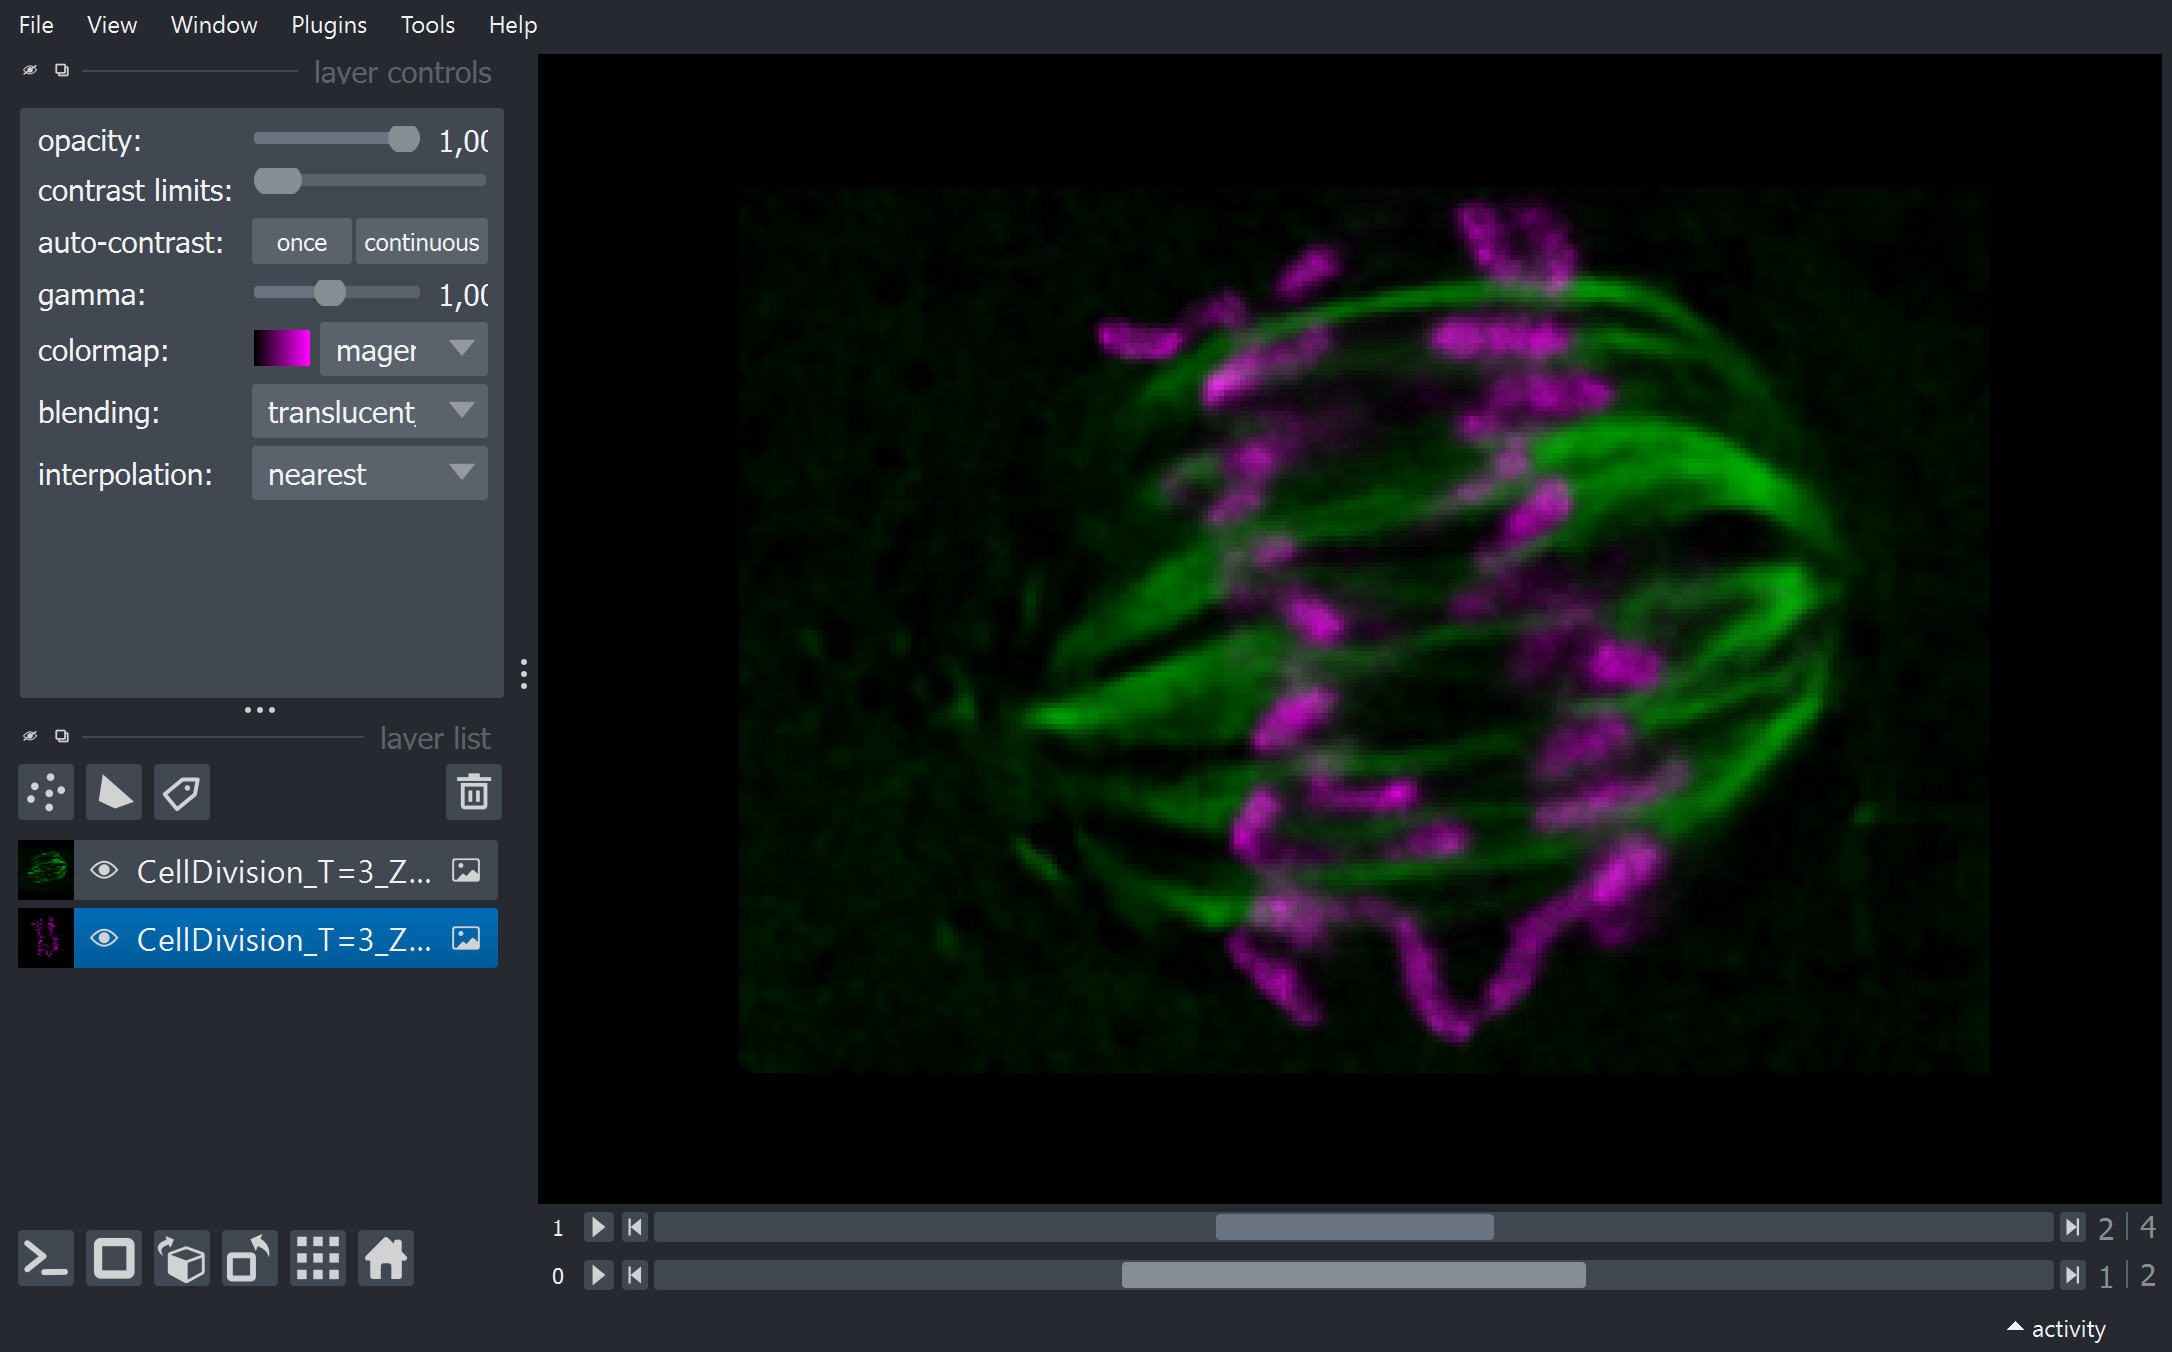

In [12]:
napari.utils.nbscreenshot(viewer)